Error analysis of the MultiResolution Analysis (MRA) coupled with Finite-Volume integration experienced on the modified equation of the 1-D linear scalar diffusion problem. 
===

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy

from sympy import I

# Introduction
In this work, we use multiresolution on nested dyadic grids that allows us to adapt the grid in a conservative manner, which is important when considering Finite-Volume methods to solve conservation laws.
The goal of this notebook is to analyze the truncation error of several classical Finite-Volume schemes coupled with the Multiresolution Analysis (MRA) applied to the 1-D linear scalar advection equation.

We consider the 1D linear scalar advection equation:

$$
    \partial_t u(t,x) - \mu(u)\, \partial_{xx} u(t,x) = 0.
$$

$u$ is the solution that is advected by a constante velocity ($a$).

We first consider a unique grid $x_k = k\, \Delta x$, where $\Delta x$ is the grid spacing that is assumed constant.
We note $u^n_k$ the solution at the point $x_k$, at time $n \, \Delta t$, where $\Delta t$ is a time step that satisfies the *Von Neumann* condition: $\displaystyle D \le \frac{1}{2}$, where $\displaystyle D = \frac{\mu \ \Delta t}{\Delta x^2}$. 

In [116]:
# independant variables
x, y, t = sy.symbols('x, y, t')

# dependant variable
u = sy.symbols('u', cls=sy.Function,nargs=2)

# indexes
i, j, k = sy.symbols('i, j, k', integer=True)
l, m, n = sy.symbols('l, m, n', integer=True)

""" space operator for diffusion with viscosity (mu(u)) """
mu  = sy.Symbol(r'\mu', positive=True)
D = sy.Symbol('D', positive=True)

# time step and grid spacing
deltat = sy.Symbol(u'\\Delta t', positive=True)
deltax = sy.Symbol(u'\\Delta x', positive=True)

In [117]:
user_degree = 5
user_theta  = 2

In [118]:
def degree_order(d, q):
    """
        Returns compatible Taylor expansion and order of scheme
    
        d int: Taylor expansion degree
        q int: Order of the OS scheme and associated stencil
    """
    if d <= (q+2):
        d = q+2
    return d, q

# symbolic version
# Taylor expansion degree
degree = sy.Symbol('degree', integer=True)
# Order of the OS scheme, and associated stencil
order = sy.Symbol(u'\\theta', integer=True)

# numerical version
degree, order = degree_order(user_degree, user_theta)

### The scheme

In [119]:
def flux_diffo2(v, jshift, D, dx):
    """
        Define the flux at the interface between celles (jshift+1), (jshift) 

        v         : the function at cell centers
        jshift int: index of the left cell of the interface
        D         : mu * Δt/Δx^2 symbol
        dx        : grid spacing
    """
    #2nd order   
    Flux_j12 = D * ( v[jshift+1] - v[jshift] ) / dx

    #4th order
    # Flux_j12 = D * ( - sy.Rational(1,12)*v[jshift+2] + sy.Rational(15,12)*v[jshift+1]
    #                  - sy.Rational(15,12)*v[jshift] +  sy.Rational(1,12)*v[jshift-1] ) / dx

    return Flux_j12

Flux = flux_diffo2

## Modified equation

In [120]:
# Taylor expansions at each point of the stencil
u0 = u(y,t).series(y, x0=x, n=degree+1).removeO().simplify()

In [121]:
u0

-(x - y)**5*Derivative(u(x, t), (x, 5))/120 + (x - y)**4*Derivative(u(x, t), (x, 4))/24 - (x - y)**3*Derivative(u(x, t), (x, 3))/6 + (x - y)**2*Derivative(u(x, t), (x, 2))/2 - (x - y)*Derivative(u(x, t), x) + u(x, t)

In [122]:
def cauchy_kovalevskaia_procedure(expr,degree):
    tmp = expr
    dxu = sy.diff(u(x,t),x,2)
    E = 0
    for m in range(degree, 0, -1):
        E =  mu**(m-1) * ( mu * u(x,t).diff(x,(2*m)) )        

        tmp = tmp.subs( sy.diff(u(x,t),t,m) , E)
        tmp = sy.collect(tmp,dxu)
        # display( " tmp = ", tmp)
    return tmp


### Calculation of the truncation error of the scheme

### Modified equation for the scheme: truncation error depending on the order ($\theta$) of the original scheme, and the *D* number ($\sigma$).

## Modified equation with MRA

In [123]:
# support width of the prediction stencil
s = sy.Symbol('s', positive=True)

# level spacing
deltal = sy.Symbol(u'\\Delta l', positive=True)

In [124]:
def MR_stencil_order(MRA, s, r=None):
    """
        MultiResolution Order (r) and support width (s) for the prediction polynomial

        MRA bool: to set if using multiresolution
        s    int: support width of the prediction stencil
        r    int: multiresolution order (if None is set to 2*s+1)
    """
    if r == None: # si r n'est pas précisé c'est l'ordre naturel de l'interpolation polynomiale à 2s+1 points. 
        r = 2*s+1
    if r>11:
        r = 11
        s = (r-1)//2
    if s == 0:
        MRA = False
    
    if not MRA:
        s = 0
        r = 1
    return MRA, s, r

user_s = 1
MRA, s, r = MR_stencil_order(True, user_s)

In [125]:
def stencil(order, s):
    """
        Define the stencil width

        order int: order of MRA
        s     int: stencil of MRA
    """
    import math
    
    # p = order

    if s == 0:
        bmin = 0
        bmax = 1
    else:
#        bmin = math.floor( -max(p, s) / 2 ) + 1 - s
#        bmax = math.floor( (max(p, s) + 1) / 2 ) + s
        bmin = - s
        bmax =  s
    
    return bmin, bmax

In [126]:
def init_omega(symbol=False):
    """
        Define the coefficients of the centered linear polynomial interpolation (s <= 5)

        symbol bool: boolean to set symbolic version with SymPy or numercial coefficients
    """
    if symbol:
        return sy.Symbol(r'\omega', positive=True)
    
    omega = sy.zeros(6, 6)

    # 3rd order
    omega[1,1] = - sy.Rational(1, 8)

    # 5th order
    omega[2,1] = - sy.Rational(22, 128)
    omega[2,2] =   sy.Rational(3, 128)

    # 7th order
    omega[3,1] = - sy.Rational(201, 1024)
    omega[3,2] =   sy.Rational(11, 256)
    omega[3,3] = - sy.Rational(5, 1024)

    # 9th order
    omega[4,1] = - sy.Rational(3461, 16384)
    omega[4,2] =   sy.Rational(949, 16384)
    omega[4,3] = - sy.Rational(185, 16384)
    omega[4,4] =   sy.Rational(35, 32768)

    # 11th order
    omega[5,1] = - sy.Rational(29011, 131072)
    omega[5,2] =   sy.Rational(569, 8192)
    omega[5,3] = - sy.Rational(4661, 262144)
    omega[5,4] =   sy.Rational(49, 16384)
    omega[5,5] = - sy.Rational(63, 262144)
    
    return omega 

In [127]:
def projection_matrix(order, s, omega=init_omega()):
    """
        Define the Projection matrix

        order       int: order of MRA
        s           int: stencil of MRA
        omega sy.Matrix: matrix of coefficients
    """
    bmin, bmax = stencil(order, s)
    # print(" bmin, bmax = ", bmin, bmax)

    P = sy.zeros(bmax-bmin+2)
    for l in range(bmin, bmax+2):
        j = (l+1)//2
        P[l-bmin,j-bmin] = 1
        for m in range(1,s+1):
            P[l-bmin,j-m-bmin] =  int((-1)**l)*omega[s,m]
            P[l-bmin,j+m-bmin] = -int((-1)**l)*omega[s,m]
    return P

s = 1
P = projection_matrix(order, s)
P

Matrix([
[ 1/8,    1, -1/8,    0],
[-1/8,    1,  1/8,    0],
[   0,  1/8,    1, -1/8],
[   0, -1/8,    1,  1/8]])

In [128]:
def truncation_error_MRA(flux, u0, mu, order, degree, MRA):
    """
        Compute truncation error of flux calculated with the OS scheme

        flux       : numerical flux function
        u0         : Taylor expansions at each point of the stencil
        mu         : Viscosity symbol
        order   int: order of scheme
        degree  int: degree of Taylor expansion
        MRA    bool: True if MRA, False otherwise
    """

    p = 4

    jshift = p
            
    dl = deltal if MRA else 0
    if MRA:
        print(f"Calcul de l'erreur de troncature avec AMR et un stencil s=1 au travers de {deltal} niveaux.")
        s=1
        P = projection_matrix(order, s)
        Pdl = P**dl
    else:
        Pdl = np.eye(4)
        print("Calcul de l'erreur de troncature sans AMR.")
    # display(" P^deltal = ", Pdl)
    
    dx = deltax*(2**dl)                                             # taille la cellule au niveau courant.
    
    uj = sy.Matrix([u0.subs(y, x+j*dx)  for j in range(-p, p+1)])   # ensemble des points u_(j+p) voisins de u_j nécessaires.

    u_star = sy.Matrix([0. for j in range(-p+2, p-1)])

    # Predicteur    
    for j in range(-p+2, p-1):
        
        uleft_proj  = Pdl * sy.Matrix([uj[l] for l in range(j+p-2, j+p+2)])     # reconstruction des voisins à gauche. 
        uright_proj = Pdl * sy.Matrix([uj[l] for l in range(j+p-1, j+p+3)])     # reconstruction des voisins à droite.
        # display(" u_proj = ", j, j+p-2, j+p+1, j+p-1, j+p+2)
        
        fr = flux(uright_proj, 1, mu, deltax)                                   # flux droit.
        fl = flux(uleft_proj, 1, mu, deltax)                                    # flux gauche.
        u_star[j+p-2] =  uj[j+p] + deltat * ( fr - fl ) / dx 
    
    # Correcteur
    uleft_proj  = Pdl * sy.Matrix([u_star[l] for l in range(0, 4)])
    uright_proj = Pdl * sy.Matrix([u_star[l] for l in range(1, 5)])
    
    fr = flux(uright_proj, 1, mu, deltax)
    fl = flux(uleft_proj, 1, mu, deltax)
    
    u_np1 = sy.Rational(1,2) * ( u(x,t) + u_star[2] + deltat * ( fr - fl ) / dx )
    
    tau = sy.Symbol('tau', postive=True)
    u_tau = u(x,tau).series(tau, x0=t, n=degree+1).removeO().simplify().subs(tau-t, deltat) 
    
    tmp = sy.expand( (u_tau - u_np1) / deltat )
    # display( "du/dt = ", tmp)

    tmp = cauchy_kovalevskaia_procedure(tmp, degree)
    
    tmp = tmp.subs(mu*deltat, D*deltax**2).collect(deltax**2)
    truncation = sy.Add(*[
                    term.factor(D) for term in tmp.args
                    ],
                    evaluate=False)
    
    # display(" Truncation = ", sy.simplify(truncation))
    
    return truncation


### Modified equation without MRA

In [129]:
MRA = False
sy.Eq(
    u(x, t).diff(t) - mu * u(x, t).diff(x,2),
    truncation_error_MRA(Flux, u0, mu, order, degree, MRA)
)

Calcul de l'erreur de troncature sans AMR.


Eq(-\mu*Derivative(u(x, t), (x, 2)) + Derivative(u(x, t), t), D**4*\Delta x**8*\mu*Derivative(u(x, t), (x, 10))/120 + D**3*\Delta x**6*\mu*Derivative(u(x, t), (x, 8))/24 + D**2*\Delta x**4*\mu*Derivative(u(x, t), (x, 6))/6 - 0.0833333333333333*\Delta x**2*\mu*Derivative(u(x, t), (x, 4)))

### Modified equation with MRA

In [130]:
MRA = True
sy.Eq(
    u(x, t).diff(t) - mu * u(x, t).diff(x,2),
    truncation_error_MRA(Flux, u0, mu, order, degree, MRA)
)

Calcul de l'erreur de troncature avec AMR et un stencil s=1 au travers de \Delta l niveaux.


Eq(-\mu*Derivative(u(x, t), (x, 2)) + Derivative(u(x, t), t), 2**(2*\Delta l)*\Delta x**2*\mu*(3*\Delta l - 1)*Derivative(u(x, t), (x, 4))/12 + D**4*\Delta x**8*\mu*Derivative(u(x, t), (x, 10))/120 + D**3*\Delta x**6*\mu*Derivative(u(x, t), (x, 8))/24 + D**2*\Delta x**4*\mu*Derivative(u(x, t), (x, 6))/6)

### Discrepancies between uniform grid and MRA for $\Delta l$ levels

In [131]:
display(" Discrepancies = ", 
    sy.simplify( truncation_error_MRA(Flux, u0, mu, order, degree, False) - 
    truncation_error_MRA(Flux, u0, mu, order, degree, True) )
    )

Calcul de l'erreur de troncature sans AMR.
Calcul de l'erreur de troncature avec AMR et un stencil s=1 au travers de \Delta l niveaux.


' Discrepancies = '

\Delta x**2*\mu*(4**\Delta l*(1 - 3*\Delta l) - 1.0)*Derivative(u(x, t), (x, 4))/12

# the Von Neumann analysis

In [132]:
ksi = sy.Symbol('\\xi')

In [170]:
def VonNeumann_MRA(flux, u0, mu, order, degree, MRA):
    """
        Compute truncation error of flux calculated with the OS scheme

        flux       : numerical flux function
        u0         : Taylor expansions at each point of the stencil
        mu         : Viscosity symbol
        order   int: order of scheme
        degree  int: degree of Taylor expansion
        MRA    bool: True if MRA, False otherwise
    """

    p = 4

    jshift = p
            
    dl = deltal if MRA else 0
    if MRA:
        s=1
        P = projection_matrix(order, s)
        Pdl = P**dl
    else:
        Pdl = np.eye(4)
    # display(" P^deltal = ", Pdl)
    
    dx = deltax*(2**dl)
    # Von Neumann number
    D = mu*deltat/deltax**2

    uj = sy.Matrix([sy.exp(I*j*ksi)  for j in range(-p, p+1)])

    u_star = sy.Matrix([0. for j in range(-p+2, p-1)])

    # Predicteur    
    for j in range(-p+2, p-1):
        
        uleft_proj  = Pdl * sy.Matrix([uj[l] for l in range(j+p-2, j+p+2)])
        uright_proj = Pdl * sy.Matrix([uj[l] for l in range(j+p-1, j+p+3)])
        # display(" u_proj = ", j, j+p-2, j+p+1, j+p-1, j+p+2)
        
        fr = flux(uright_proj, 1, mu, deltax) 
        fl = flux(uleft_proj, 1, mu, deltax)
        u_star[j+p-2] =  uj[j+p] + deltat * ( fr - fl ) / dx 
    
    display(" u^(1) = ", u_star[2])
    
    # Correcteur
    uleft_proj  = Pdl * sy.Matrix([u_star[l] for l in range(0, 4)])
    uright_proj = Pdl * sy.Matrix([u_star[l] for l in range(1, 5)])
    
    fr = flux(uright_proj, 1, mu, deltax)
    fl = flux(uleft_proj, 1, mu, deltax)
    
    u_np1 = sy.Rational(1,2) * ( 1 + u_star[2] + deltat * ( fr - fl ) / dx )

    tmp = u_np1.subs(mu*deltat, D*deltax**2).collect(deltax**2)
        
    # display(" u^(n+1) = ", sy.simplify(tmp).expand())
    
    return tmp





In [173]:
MRA = False
user_deltal = 2 if MRA else 0

unp1 = VonNeumann_MRA(Flux, u0, mu, order, degree, MRA)

unp1 = unp1.subs(deltal, user_deltal).expand().rewrite(sy.cos)
unp1 = unp1.subs(mu*deltat, D*deltax**2).collect(deltax**2)
display(" u^(n+1) = ", unp1.rewrite(sy.cos))

' u^(1) = '

\Delta t*(-\mu*(1.0 - 1.0*exp(-I*\xi))/\Delta x + \mu*(1.0*exp(I*\xi) - 1.0)/\Delta x)/\Delta x + 1

' u^(n+1) = '

-2.0*D**2*(cos(\xi) - I*cos(\xi - pi/2)) - 2.0*D**2*(cos(\xi) + I*cos(\xi - pi/2)) + 0.5*D**2*(cos(2*\xi) - I*cos(2*\xi - pi/2)) + 0.5*D**2*(cos(2*\xi) + I*cos(2*\xi - pi/2)) + 3.0*D**2 + 1.0*D*(cos(\xi) - I*cos(\xi - pi/2)) + 1.0*D*(cos(\xi) + I*cos(\xi - pi/2)) - 2.0*D + 1

In [155]:
n_ksi = np.linspace(0, np.pi, 100)
n_VN = np.linspace(0.1, 1, 5)

# prescribed a specific Δl
n_deltal = np.array([user_deltal])

M_ksi, M_VN, M_deltal = np.meshgrid( n_ksi, n_VN, n_deltal )

In [156]:
G = sy.lambdify( (ksi, D, deltal) , unp1.evalf() , 'numpy' )
data = G( M_ksi, M_VN, M_deltal )

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


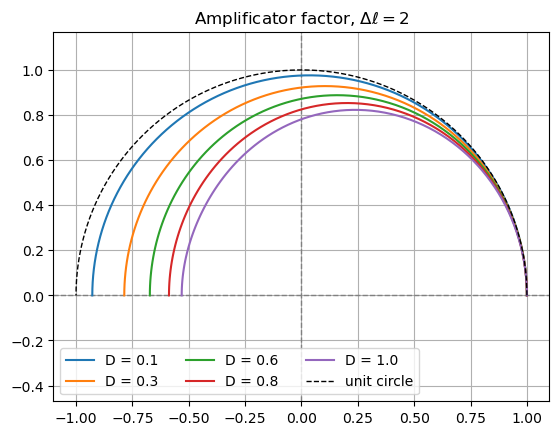

In [157]:
plt.axhline(0, 0, 1, color="gray", linestyle="--", linewidth=1)
plt.axvline(0, 0, 1, color="gray", linestyle="--", linewidth=1)
plt.grid(visible=True)

for i, sigma in enumerate(n_VN):
    xy = np.absolute(data[i,:,0]) * np.exp(1j*n_ksi)
    plt.plot( xy.real , xy.imag , label=f"D = {sigma:.1f}" )

plt.plot( np.exp(1j*n_ksi).real , np.exp(1j*n_ksi).imag , "--" , color="black", linewidth=1, label="unit circle" )

plt.title(f"Amplificator factor, $\\Delta \\ell = {n_deltal[0]}$")
plt.axis("equal")
plt.legend(ncol=3)
plt.ylim(-0.4, 1.1)

plt.show()

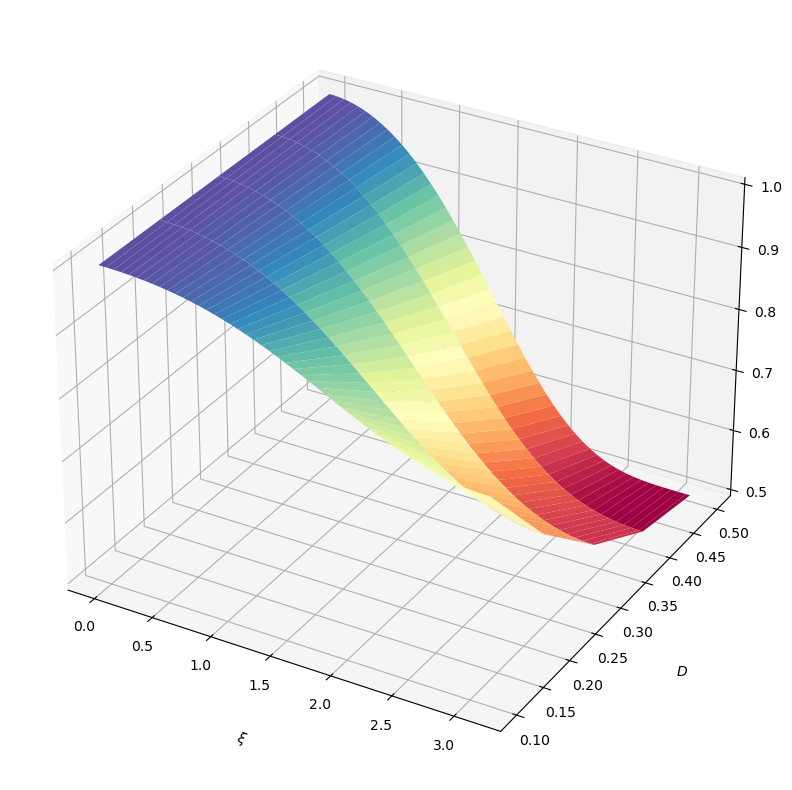

In [138]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(M_ksi[:,:,0], M_VN[:,:,0], np.absolute(data[:,:,0]), cmap = plt.cm.Spectral)

# Set axes label
ax.set_xlabel(r"$\xi$", labelpad=20)
ax.set_ylabel(r"$D$", labelpad=20)
ax.set_zlabel('amplificator factor', labelpad=20)

plt.show()

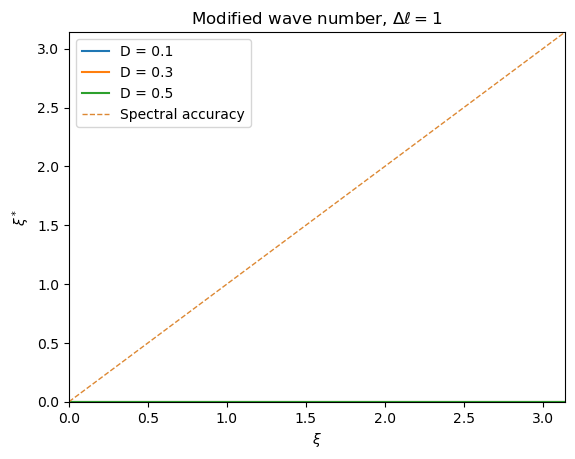

In [139]:
for i, sigma in list(enumerate(n_VN))[::2]:
    plt.plot( n_ksi , -np.angle(data[i,:,0], deg=False)/sigma , label=f"D = {sigma:.1f}" )

plt.plot( n_ksi , n_ksi , "--" , color="#dd8833", linewidth=1, label="Spectral accuracy" )

plt.xlabel(r"$\xi$");   plt.xlim(n_ksi[0], n_ksi[-1])
plt.ylabel(r"$\xi^*$"); plt.ylim(0, np.pi)
plt.title(f"Modified wave number, $\\Delta \\ell = {n_deltal[0]}$")
plt.legend()
plt.show()

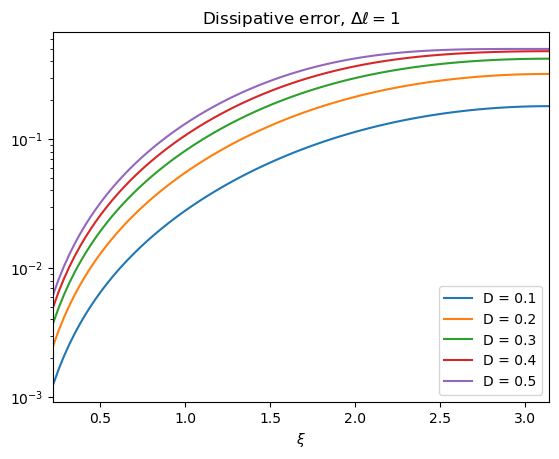

In [140]:
ifirst = len(n_ksi[n_ksi < np.pi/16]) # to not display log of 0

for i, sigma in enumerate(n_VN):
    plt.plot( n_ksi[ifirst:] , 1-np.absolute(data[i,ifirst:,0]) , label=f"D = {sigma:.1f}" )

# plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\xi$");   plt.xlim(n_ksi[ifirst], n_ksi[-1])
plt.title(f"Dissipative error, $\\Delta \\ell = {n_deltal[0]}$")
plt.legend()
plt.show()

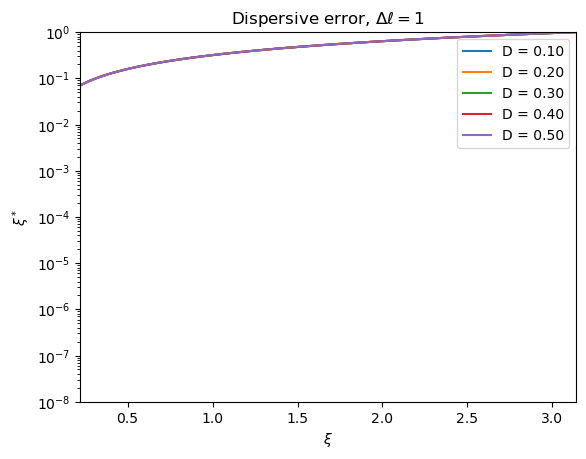

In [141]:
ifirst = len(n_ksi[n_ksi < np.pi/16]) # to not display log of 0

for i, sigma in enumerate(n_VN):
    eta = n_ksi[ifirst:]
    plt.plot( eta , np.absolute(eta+np.angle(data[i,ifirst:,0],deg=False)/sigma)/np.pi , label=f"D = {sigma:.2f}" )
    
# plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\xi$");   plt.xlim(n_ksi[ifirst], n_ksi[-1])
plt.ylabel(r"$\xi^*$"); plt.ylim(1.e-8, 1.)
plt.title(f"Dispersive error, $\\Delta \\ell = {n_deltal[0]}$")
plt.legend()
plt.show()

## Analysis of MRA solution with fluxes estimated on highest level ($l + \Delta l$) compared to uniform grid at the coarse level ($l$) 

In [142]:
def truncation_error(flux, u0, mu, order, degree):
    """
        Compute truncation error of flux calculated with the OS scheme

        flux       : numerical flux function
        u0         : Taylor expansions at each point of the stencil
        mu         : Viscosity symbol
        order   int: order of scheme
        degree  int: degree of Taylor expansion
    """

    p = 4

    jshift = p
               
    dx = deltax*(2**deltal)

    uj = sy.Matrix([u0.subs(y, x+j*dx)  for j in range(-p, p+1)])

    u_star = sy.Matrix([0. for j in range(-p+2, p-1)])

    # Predicteur    
    for j in range(-p+2, p-1):
        
        uleft_proj  = sy.Matrix([uj[l] for l in range(j+p-2, j+p+2)])
        uright_proj = sy.Matrix([uj[l] for l in range(j+p-1, j+p+3)])
        # display(" u_proj = ", j, j+p-2, j+p+1, j+p-1, j+p+2)
        
        fr = flux(uright_proj, 1, mu, dx) 
        fl = flux(uleft_proj, 1, mu, dx)
        u_star[j+p-2] =  uj[j+p] + deltat * ( fr - fl ) / dx 
    
    # Correcteur
    uleft_proj  = sy.Matrix([u_star[l] for l in range(0, 4)])
    uright_proj = sy.Matrix([u_star[l] for l in range(1, 5)])
    
    fr = flux(uright_proj, 1, mu, dx)
    fl = flux(uleft_proj, 1, mu, dx)
    
    u_np1 = sy.Rational(1,2) * ( u(x,t) + u_star[2] + deltat * ( fr - fl ) / dx )
    
    tau = sy.Symbol('tau', postive=True)
    u_tau = u(x,tau).series(tau, x0=t, n=degree+1).removeO().simplify().subs(tau-t, deltat) 
 
    tmp = sy.expand( (u_tau - u_np1) / deltat )
    # display( "du/dt = ", tmp)

    tmp = cauchy_kovalevskaia_procedure(tmp, degree)
    
    tmp = tmp.subs(mu*deltat, D*dx**2).collect(deltax**2)
    truncation = sy.Add(*[
                     term.factor(D)
                     for term in tmp.args
                 ], evaluate=False)
    
    # display(" Truncation = ", sy.simplify(truncation))
    
    return truncation


In [143]:
sy.Eq(
    u(x, t).diff(t) - mu * u(x, t).diff(x,2),
    truncation_error(Flux, u0, mu, order, degree)
)

Eq(-\mu*Derivative(u(x, t), (x, 2)) + Derivative(u(x, t), t), 2**(8*\Delta l)*D**4*\Delta x**8*\mu*Derivative(u(x, t), (x, 10))/120 + 2**(6*\Delta l)*D**3*\Delta x**6*\mu*Derivative(u(x, t), (x, 8))/24 + 2**(4*\Delta l)*D**2*\Delta x**4*\mu*Derivative(u(x, t), (x, 6))/6 - 2**(2*\Delta l)*\Delta x**2*\mu*Derivative(u(x, t), (x, 4))/12)

In [144]:
MRA = True
sy.Eq(
    u(x, t).diff(t) - mu * u(x, t).diff(x,2),
    truncation_error_MRA(Flux, u0, mu, order, degree, MRA)
)

Calcul de l'erreur de troncature avec AMR et un stencil s=1 au travers de \Delta l niveaux.


Eq(-\mu*Derivative(u(x, t), (x, 2)) + Derivative(u(x, t), t), 2**(2*\Delta l)*\Delta x**2*\mu*(3*\Delta l - 1)*Derivative(u(x, t), (x, 4))/12 + D**4*\Delta x**8*\mu*Derivative(u(x, t), (x, 10))/120 + D**3*\Delta x**6*\mu*Derivative(u(x, t), (x, 8))/24 + D**2*\Delta x**4*\mu*Derivative(u(x, t), (x, 6))/6)

In [145]:
display(" Discrepancies = ", 
    sy.simplify( truncation_error(Flux, u0, mu, order, degree) - 
    truncation_error_MRA(Flux, u0, mu, order, degree, True) )
    )

Calcul de l'erreur de troncature avec AMR et un stencil s=1 au travers de \Delta l niveaux.


' Discrepancies = '

\Delta x**2*\mu*(20*2**(4*\Delta l)*D**2*\Delta x**2*Derivative(u(x, t), (x, 6)) - 30*2**(2*\Delta l)*\Delta l*Derivative(u(x, t), (x, 4)) + 256**\Delta l*D**4*\Delta x**6*Derivative(u(x, t), (x, 10)) + 5*64**\Delta l*D**3*\Delta x**4*Derivative(u(x, t), (x, 8)) - D**4*\Delta x**6*Derivative(u(x, t), (x, 10)) - 5*D**3*\Delta x**4*Derivative(u(x, t), (x, 8)) - 20*D**2*\Delta x**2*Derivative(u(x, t), (x, 6)))/120